In [39]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
data = pd.read_csv('Diabetes.csv')

X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [43]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [44]:
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)

In [45]:
def circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

In [46]:
n_layers = 3
weights_shape = (n_layers, n_qubits, 3)
weights = np.random.randn(*weights_shape, requires_grad=True)
qnode = qml.QNode(circuit, dev)

In [47]:
def quantum_model(weights, X):
    predictions = np.array([qnode(weights, x) for x in X])
    return predictions

def cost(weights, X, y):
    predictions = quantum_model(weights, X)
    loss = np.mean((predictions - y)**2)
    return loss

In [48]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)
steps = 20
loss_history = []

In [49]:
for i in range(steps):
    weights, loss = opt.step_and_cost(lambda w: cost(w, X_train, y_train), weights)
    loss_history.append(loss)
    print(f"Step {i}: Loss = {loss}")

Step 0: Loss = 0.3407826439106503
Step 1: Loss = 0.3407724797748301
Step 2: Loss = 0.3407623240175167
Step 3: Loss = 0.3407521766225444
Step 4: Loss = 0.34074203757378435
Step 5: Loss = 0.34073190685514454
Step 6: Loss = 0.34072178445056955
Step 7: Loss = 0.3407116703440404
Step 8: Loss = 0.34070156451957484
Step 9: Loss = 0.34069146696122676
Step 10: Loss = 0.3406813776530864
Step 11: Loss = 0.3406712965792803
Step 12: Loss = 0.34066122372397084
Step 13: Loss = 0.34065115907135657
Step 14: Loss = 0.34064110260567193
Step 15: Loss = 0.34063105431118706
Step 16: Loss = 0.34062101417220797
Step 17: Loss = 0.34061098217307617
Step 18: Loss = 0.3406009582981686
Step 19: Loss = 0.3405909425318979


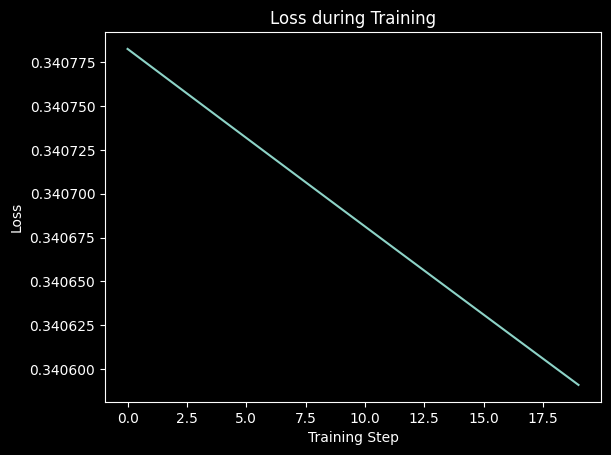

In [50]:
plt.plot(range(steps), loss_history)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.show()

In [51]:
X_test = np.array(X_test)
y_test = np.array(y_test)
predictions_test = quantum_model(weights, X_test)

In [52]:
predictions_test_binary = (predictions_test > 0.5).astype(int)

In [53]:
accuracy = np.mean(predictions_test_binary == y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 64.29%


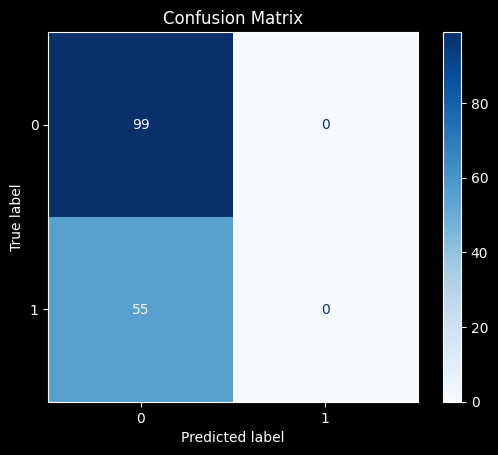

In [54]:
cm = confusion_matrix(y_test, predictions_test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()